# Parkinson's Disease Detection from Voice using Domain Adaptation

Este notebook replica el pipeline del paper "Towards a Corpus (and Language)-Independent Screening of Parkinson's Disease from Voice and Speech through Domain Adaptation" utilizando la base de datos de vocales.

## Objetivos:
1. Cargar y preprocesar datos de audio de vocales
2. Extraer características acústicas relevantes
3. Implementar técnicas de adaptación de dominio
4. Entrenar modelos de deep learning para clasificación
5. Evaluar el rendimiento del sistema

## Compatibilidad:
- ✅ Ejecutable localmente
- ✅ Ejecutable en Google Colab


In [1]:
# Instalación de dependencias (solo necesario en Colab)
import sys
import os

# Detectar si estamos en Colab
try:
    import google.colab
    IN_COLAB = True
    print("🚀 Ejecutando en Google Colab")
except ImportError:
    IN_COLAB = False
    print("💻 Ejecutando localmente")

# Instalar dependencias si estamos en Colab
if IN_COLAB:
    %pip install librosa soundfile scikit-learn matplotlib seaborn pandas numpy
    %pip install torch torchvision torchaudio tqdm
    # Montar Google Drive si es necesario
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Asegúrate de tener instaladas las siguientes librerías:")
    print("- librosa, soundfile, scikit-learn")
    print("- matplotlib, seaborn, pandas, numpy")
    print("- torch, torchvision, torchaudio (FRAMEWORK PRINCIPAL)")
    print("- tqdm (para barras de progreso)")
    
    # Instalar tqdm si no está disponible
    try:
        from tqdm import tqdm
        print("✅ tqdm ya está instalado")
    except ImportError:
        print("⚠️ Instalando tqdm...")
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "tqdm"])
        from tqdm import tqdm
        print("✅ tqdm instalado correctamente")


💻 Ejecutando localmente
Asegúrate de tener instaladas las siguientes librerías:
- librosa, soundfile, scikit-learn
- matplotlib, seaborn, pandas, numpy
- torch, torchvision, torchaudio (FRAMEWORK PRINCIPAL)
- tqdm (para barras de progreso)
✅ tqdm ya está instalado


In [2]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Deep Learning - PyTorch (Framework Principal)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

# Configuración de matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configuración de PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Usando dispositivo: {device}")

print("✅ Todas las librerías importadas correctamente")
print(f"PyTorch version: {torch.__version__}")
print(f"Librosa version: {librosa.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


🔧 Usando dispositivo: cpu
✅ Todas las librerías importadas correctamente
PyTorch version: 2.8.0+cpu
Librosa version: 0.11.0
CUDA disponible: False


## 1. Configuración del Entorno y Carga de Datos

Primero, vamos a configurar las rutas de datos y explorar la estructura del dataset de vocales.


In [3]:
# Configuración de rutas de datos
if IN_COLAB:
    # En Colab, asumimos que los datos están en Google Drive
    DATA_PATH = "/content/drive/MyDrive/parkinson-voice-uncertainty/vowels"
else:
    # Localmente, usar la ruta relativa
    DATA_PATH = "./vowels"

# Verificar que la ruta existe
if os.path.exists(DATA_PATH):
    print(f"✅ Directorio de datos encontrado: {DATA_PATH}")
    
    # Listar archivos disponibles
    audio_files = list(Path(DATA_PATH).glob("*.egg"))
    nsp_files = list(Path(DATA_PATH).glob("*.nsp"))
    
    print(f"📁 Archivos de audio (.egg): {len(audio_files)}")
    print(f"📁 Archivos de metadatos (.nsp): {len(nsp_files)}")
    
    # Mostrar algunos ejemplos
    print("\n🔍 Primeros 5 archivos de audio:")
    for i, file in enumerate(audio_files[:5]):
        print(f"  {i+1}. {file.name}")
        
else:
    print(f"❌ No se encontró el directorio: {DATA_PATH}")
    print("Asegúrate de que los datos estén en la ubicación correcta")


✅ Directorio de datos encontrado: ./vowels
📁 Archivos de audio (.egg): 13
📁 Archivos de metadatos (.nsp): 13

🔍 Primeros 5 archivos de audio:
  1. 1580-a_h-egg.egg
  2. 1580-a_l-egg.egg
  3. 1580-a_lhl-egg.egg
  4. 1580-a_n-egg.egg
  5. 1580-iau-egg.egg


## 2. Carga y Preprocesamiento de Audio

Ahora vamos a implementar funciones para cargar y preprocesar los archivos de audio. Los archivos `.egg` parecen ser archivos de audio binarios que necesitamos procesar.


In [4]:
# PREPROCESAMIENTO EXACTO DEL PAPER
# Basado en: "Towards a Corpus (and Language)-Independent Screening of Parkinson's Disease from Voice and Speech through Domain Adaptation"

def load_audio_file(file_path, target_sr=44100):
    """
    Carga un archivo de audio y resamplea a 44.1 kHz (como en el paper)
    
    Args:
        file_path: Ruta al archivo de audio
        target_sr: Frecuencia de muestreo objetivo (44.1 kHz según paper)
    
    Returns:
        audio: Señal de audio resampleada
        sr: Frecuencia de muestreo (44.1 kHz)
    """
    try:
        # Cargar audio con librosa
        audio, original_sr = librosa.load(file_path, sr=None)  # Cargar con SR original
        
        # Resamplear a 44.1 kHz (como especifica el paper)
        if original_sr != target_sr:
            audio = librosa.resample(audio, orig_sr=original_sr, target_sr=target_sr)
        
        return audio, target_sr
    except Exception as e:
        print(f"Error cargando {file_path}: {e}")
        return None, None

def segment_audio(audio, sr=44100, window_duration=0.4, overlap=0.5):
    """
    Segmenta el audio en ventanas de 400ms con 50% solapamiento (como en el paper)
    
    Args:
        audio: Señal de audio
        sr: Frecuencia de muestreo
        window_duration: Duración de ventana en segundos (0.4s = 400ms)
        overlap: Solapamiento entre ventanas (0.5 = 50%)
    
    Returns:
        segments: Lista de segmentos de audio
    """
    window_samples = int(window_duration * sr)
    hop_samples = int(window_samples * (1 - overlap))
    
    segments = []
    
    for start in range(0, len(audio) - window_samples + 1, hop_samples):
        end = start + window_samples
        segment = audio[start:end]
        segments.append(segment)
    
    return segments

def create_mel_spectrogram(segment, sr=44100, n_mels=65, hop_length=None, 
                          window_length=None, vowel_type='a'):
    """
    Crea espectrogramas Mel con parámetros específicos del paper para DATASET DE VOCALES
    
    Args:
        segment: Segmento de audio
        sr: Frecuencia de muestreo (44.1 kHz)
        n_mels: Número de bandas Mel (65 según paper)
        hop_length: Hop length en muestras (10ms según paper)
        window_length: Longitud de ventana FFT
        vowel_type: Tipo de vocal ('a', 'e', 'i', 'o', 'u', 'iau', etc.)
    
    Returns:
        mel_spec: Espectrograma Mel en dB
    """
    # Parámetros según el paper
    if hop_length is None:
        hop_length = int(0.01 * sr)  # 10ms hop
    
    # Ventanas FFT específicas para DATASET DE VOCALES (CORREGIDO)
    if vowel_type == 'a':
        window_length = int(0.04 * sr)  # 40ms SOLO para /a/ (estacionariedad)
        print(f"  📊 Vocal /a/ detectada: usando ventana FFT de 40ms")
    else:
        # Para TODAS las demás vocales (/e/, /i/, /o/, /u/, /iau/, etc.)
        # En el dataset de vowels NO hay DDK, solo vocales
        window_length = int(0.025 * sr)  # 25ms configuración "normal"
        print(f"  📊 Vocal {vowel_type}: usando ventana FFT de 25ms (configuración normal)")
    
    # Crear espectrograma Mel
    mel_spec = librosa.feature.melspectrogram(
        y=segment,
        sr=sr,
        n_mels=n_mels,
        hop_length=hop_length,
        n_fft=window_length,
        fmax=sr//2
    )
    
    # Convertir a dB
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    return mel_spec_db

def normalize_spectrogram(mel_spec_db):
    """
    Normalización z-score del espectrograma (como en el paper)
    
    Args:
        mel_spec_db: Espectrograma Mel en dB
    
    Returns:
        normalized_spec: Espectrograma normalizado con z-score
    """
    # Calcular media y desviación estándar
    mean_val = np.mean(mel_spec_db)
    std_val = np.std(mel_spec_db)
    
    # Aplicar z-score normalization
    normalized_spec = (mel_spec_db - mean_val) / (std_val + 1e-8)
    
    return normalized_spec

def preprocess_audio_paper(file_path, vowel_type='a'):
    """
    Pipeline completo de preprocesamiento según el paper
    
    Args:
        file_path: Ruta al archivo de audio
        vowel_type: Tipo de vocal/condición
    
    Returns:
        spectrograms: Lista de espectrogramas Mel normalizados (65×41)
        segments: Segmentos de audio originales
    """
    # 1. Cargar y resamplear a 44.1 kHz
    audio, sr = load_audio_file(file_path, target_sr=44100)
    
    if audio is None:
        return None, None
    
    # 2. Segmentar en ventanas de 400ms con 50% solapamiento
    segments = segment_audio(audio, sr=sr, window_duration=0.4, overlap=0.5)
    
    # 3. Crear espectrogramas Mel para cada segmento
    spectrograms = []
    
    for segment in segments:
        # Crear espectrograma Mel (65 bandas, hop 10ms)
        mel_spec = create_mel_spectrogram(
            segment, sr=sr, n_mels=65, 
            hop_length=int(0.01 * sr),  # 10ms hop
            vowel_type=vowel_type
        )
        
        # Normalizar con z-score
        normalized_spec = normalize_spectrogram(mel_spec)
        
        # Asegurar dimensiones 65×41 (como especifica el paper)
        if normalized_spec.shape[1] != 41:
            # Interpolar o truncar para obtener exactamente 41 frames
            normalized_spec = librosa.util.fix_length(normalized_spec, size=41, axis=1)
        
        spectrograms.append(normalized_spec)
    
    return spectrograms, segments


In [5]:
# ==============================
# Clean dataset pipeline (PyTorch-ready)
# ==============================
from __future__ import annotations

from dataclasses import dataclass
from typing import Callable, Dict, Iterable, List, Optional, Sequence, Tuple
from collections import Counter, defaultdict

# -------------------------------------------------
# Config / Types
# -------------------------------------------------

@dataclass(frozen=True)
class SampleMeta:
    """Lightweight metadata holder for each audio segment."""
    subject_id: str
    vowel_type: str
    condition: str
    filename: str
    segment_id: int
    sr: int

PreprocessFn = Callable[["os.PathLike[str] | str", Optional[str]], Tuple[List[np.ndarray], List[np.ndarray]]]
# Se asume que existe una función externa `preprocess_audio_paper(path, vowel_type=...)`
# con la firma compatible a PreprocessFn que devuelve (spectrograms, segments)

# -------------------------------------------------
# Helpers
# -------------------------------------------------

def _safe_len(x: Optional[Sequence]) -> int:
    """Return 0 when x is None."""
    return len(x) if x is not None else 0

def _print_progress(i: int, total: int, path_name: str, every: int) -> None:
    """Print compact progress every N files."""
    if i % max(1, every) == 0:
        print(f"  {i+1}/{total}: {path_name}")

def parse_filename(file_stem: str) -> Tuple[str, str, str]:
    """
    Parse a filename stem into (subject_id, vowel_type, condition).

    Rules:
    - Split by '-'
    - Missing pieces get sensible defaults.
    """
    parts = file_stem.split('-')
    subject_id = parts[0] if len(parts) > 0 and parts[0] else "unknown"
    vowel_type = parts[1] if len(parts) > 1 and parts[1] else "a"
    condition  = parts[2] if len(parts) > 2 and parts[2] else "unknown"
    return subject_id, vowel_type, condition

def build_domain_index(vowels: Iterable[str]) -> Dict[str, int]:
    """
    Create a deterministic domain index per vowel (0..K-1) without using hash().
    Ensures reproducibility across runs and machines.
    """
    uniq = sorted(set(vowels))
    return {v: idx for idx, v in enumerate(uniq)}

def map_condition_to_task(condition: str) -> int:
    """
    Map condition labels to a binary task (0=Control, 1=Parkinson).
    Adjust here to fit your dataset semantics.
    """
    mapping = {
        "h": 1,     # Parkinson
        "l": 0,     # Control
        "n": 0,     # Control
        "lhl": 1,   # Parkinson
    }
    return mapping.get(condition, 0)

# -------------------------------------------------
# Core
# -------------------------------------------------

def process_dataset(
    audio_files: Sequence,
    preprocess_fn: PreprocessFn,
    max_files: Optional[int] = None,
    progress_every: int = 10,
    default_sr: int = 44100
) -> List[Dict]:
    """
    Process the dataset using the paper's preprocessing function.

    Args:
        audio_files: Iterable of pathlib.Path-like objects.
        preprocess_fn: Callable that returns (spectrograms, segments) per file.
        max_files: Optional cap on number of files to process.
        progress_every: Print progress every N files.
        default_sr: Sampling rate to attach to metadata (if unknown externally).

    Returns:
        A list of dict samples with spectrograms, segments, and metadata.
    """
    if not audio_files:
        print("❌ 'audio_files' está vacío: no hay nada que procesar.")
        return []

    files_to_process = list(audio_files[:max_files]) if max_files else list(audio_files)
    print(f"🔄 Procesando {len(files_to_process)} archivos...")

    dataset: List[Dict] = []

    for i, file_path in enumerate(files_to_process):
        _print_progress(i, len(files_to_process), getattr(file_path, "name", str(file_path)), progress_every)

        subject_id, vowel_type, condition = parse_filename(getattr(file_path, "stem", str(file_path)))
        # Llamada al preprocesamiento (del paper)
        try:
            spectrograms, segments = preprocess_fn(file_path, vowel_type=vowel_type)
        except Exception as e:
            print(f"⚠️  Error al procesar {file_path}: {e}. Continuando…")
            continue

        if not spectrograms:
            # Nada que agregar de este archivo
            continue

        # Empaquetar muestras
        for j, (spec, seg) in enumerate(zip(spectrograms, segments)):
            dataset.append({
                "spectrogram": spec,     # numpy array 2D
                "segment": seg,          # numpy array 1D (si aplica)
                "metadata": SampleMeta(
                    subject_id=subject_id,
                    vowel_type=vowel_type,
                    condition=condition,
                    filename=getattr(file_path, "name", str(file_path)),
                    segment_id=j,
                    sr=default_sr
                )
            })

    print(f"✅ {len(dataset)} muestras generadas")
    return dataset

def to_pytorch_tensors(dataset: List[Dict]) -> Tuple[Optional[torch.Tensor], Optional[torch.Tensor], Optional[torch.Tensor], List[SampleMeta]]:
    """
    Convert the processed dataset to PyTorch tensors.

    Returns:
        X        : FloatTensor (N, 1, H, W) spectrograms
        y_task   : LongTensor (N,)     task labels
        y_domain : LongTensor (N,)     domain labels (by vowel)
        metas    : List[SampleMeta]    metadata list
    """
    if not dataset:
        print("❌ Dataset vacío: no hay tensores que crear.")
        return None, None, None, []

    # Extraer metadatos y espectrogramas
    metas: List[SampleMeta] = [sample["metadata"] for sample in dataset]
    vowels = [m.vowel_type for m in metas]
    domain_index = build_domain_index(vowels)

    specs: List[np.ndarray] = []
    y_task: List[int] = []
    y_domain: List[int] = []

    for sample in dataset:
        spec: np.ndarray = sample["spectrogram"]
        if spec.ndim != 2:
            raise ValueError(f"Spectrogram must be 2D, got shape: {spec.shape}")

        # canal = 1 para CNN 2D
        specs.append(np.expand_dims(spec, axis=0))          # (1, H, W)
        y_task.append(map_condition_to_task(sample["metadata"].condition))
        y_domain.append(domain_index[sample["metadata"].vowel_type])

    X = torch.from_numpy(np.stack(specs, axis=0)).float()   # (N, 1, H, W)
    y_task_t = torch.tensor(y_task, dtype=torch.long)       # (N,)
    y_domain_t = torch.tensor(y_domain, dtype=torch.long)   # (N,)

    # Reporte compacto
    print("📊 PyTorch tensors listos:")
    print(f"  - X: {tuple(X.shape)}")
    print(f"  - y_task: {tuple(y_task_t.shape)}  (dist={dict(Counter(y_task))})")
    print(f"  - y_domain: {tuple(y_domain_t.shape)}  (K dominios={len(domain_index)})")

    return X, y_task_t, y_domain_t, metas

# -------------------------------------------------
# Torch Dataset (opcional pero útil)
# -------------------------------------------------

class VowelSegmentsDataset(torch.utils.data.Dataset):
    """
    A thin PyTorch Dataset wrapper for training.
    """
    def __init__(self, X: torch.Tensor, y_task: torch.Tensor, y_domain: torch.Tensor, metas: List[SampleMeta]):
        assert X is not None and y_task is not None and y_domain is not None, "Tensors must not be None"
        assert len(X) == len(y_task) == len(y_domain) == len(metas), "Length mismatch between tensors and metadata"
        self.X = X
        self.y_task = y_task
        self.y_domain = y_domain
        self.metas = metas

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx: int):
        return {
            "X": self.X[idx],                 # (1, H, W)
            "y_task": self.y_task[idx],       # scalar
            "y_domain": self.y_domain[idx],   # scalar
            "meta": self.metas[idx]           # SampleMeta
        }

# -------------------------------------------------
# Summary utilities (distribuciones)
# -------------------------------------------------

def summarize_distribution(dataset: List[Dict]) -> Dict[str, Counter]:
    """
    Compute distributions by vowel and condition from dataset metadata.
    """
    vowels = Counter()
    conditions = Counter()
    for sample in dataset:
        m: SampleMeta = sample["metadata"]
        vowels[m.vowel_type] += 1
        conditions[m.condition] += 1
    return {"vowel": vowels, "condition": conditions}

def print_summary(dist: Dict[str, Counter]) -> None:
    """Pretty-print distributions."""
    print("\n📊 DISTRIBUCIÓN POR VOCAL:")
    for k, v in dist["vowel"].items():
        print(f"  - {k}: {v} muestras")
    print("\n📊 DISTRIBUCIÓN POR CONDICIÓN:")
    for k, v in dist["condition"].items():
        print(f"  - {k}: {v} muestras")

# -------------------------------------------------
# Orquestación (segura para celdas posteriores)
# -------------------------------------------------

def build_full_pipeline(
    audio_files: Optional[Sequence],
    preprocess_fn: PreprocessFn,
    max_files: Optional[int] = None
):
    """
    One-shot pipeline to produce:
      - raw dataset (list of dicts)
      - PyTorch tensors (X, y_task, y_domain)
      - torch Dataset (VowelSegmentsDataset)
      - summary distributions
    Returns robust empty outputs if audio_files is None or empty.
    """
    if not audio_files:
        print("❌ 'audio_files' no está definido o viene vacío. No se procesó nada.")
        return {
            "dataset": [],
            "tensors": (None, None, None),
            "torch_ds": None,
            "metadata": [],
            "summary": {"vowel": Counter(), "condition": Counter()}
        }

    dataset = process_dataset(
        audio_files=audio_files,
        preprocess_fn=preprocess_fn,
        max_files=max_files
    )

    if not dataset:
        print("❌ No se pudo construir el dataset. Revisa el preprocesamiento y los archivos.")
        return {
            "dataset": [],
            "tensors": (None, None, None),
            "torch_ds": None,
            "metadata": [],
            "summary": {"vowel": Counter(), "condition": Counter()}
        }

    X, y_task, y_domain, metas = to_pytorch_tensors(dataset)
    torch_ds = VowelSegmentsDataset(X, y_task, y_domain, metas) if X is not None else None
    dist = summarize_distribution(dataset)
    print_summary(dist)

    print("\n✅ Dataset COMPLETO listo para entrenamiento con PyTorch!")
    print(f"  - Muestras totales: {len(dataset)}")
    if X is not None:
        print(f"  - Dimensiones de entrada: {tuple(X.shape)}")
        print("  - Ideal para CNN 2D")

    return {
        "dataset": dataset,
        "tensors": (X, y_task, y_domain),
        "torch_ds": torch_ds,
        "metadata": metas,
        "summary": dist
    }

# ==============================
# USO (ejecutar pipeline completo)
# ==============================
try:
    results = build_full_pipeline(
        audio_files=audio_files,                   # Debe ser una lista de Path
        preprocess_fn=preprocess_audio_paper,      # Ya definida en celdas anteriores
        max_files=None                             # None = todos
    )
    # Variables útiles para celdas posteriores:
    dataset = results["dataset"]
    complete_dataset = results["dataset"]  # Compatibilidad con celdas posteriores
    (X_torch_complete, y_task_torch_complete, y_domain_torch_complete) = results["tensors"]
    metadata_complete = results["metadata"]
    torch_dataset = results["torch_ds"]
except NameError as e:
    print(f"❌ Error: {e}")
    print("   Define 'audio_files' y 'preprocess_audio_paper' antes de ejecutar la tubería.")
    dataset = []
    complete_dataset = []
    X_torch_complete = y_task_torch_complete = y_domain_torch_complete = None
    metadata_complete = []
    torch_dataset = None


🔄 Procesando 13 archivos...
  1/13: 1580-a_h-egg.egg
  📊 Vocal a_h: usando ventana FFT de 25ms (configuración normal)
  📊 Vocal a_l: usando ventana FFT de 25ms (configuración normal)
  📊 Vocal a_l: usando ventana FFT de 25ms (configuración normal)
  📊 Vocal a_lhl: usando ventana FFT de 25ms (configuración normal)
  📊 Vocal a_lhl: usando ventana FFT de 25ms (configuración normal)
  📊 Vocal a_lhl: usando ventana FFT de 25ms (configuración normal)
  📊 Vocal a_n: usando ventana FFT de 25ms (configuración normal)
  📊 Vocal a_n: usando ventana FFT de 25ms (configuración normal)
  📊 Vocal iau: usando ventana FFT de 25ms (configuración normal)
  📊 Vocal iau: usando ventana FFT de 25ms (configuración normal)
  📊 Vocal iau: usando ventana FFT de 25ms (configuración normal)
  📊 Vocal iau: usando ventana FFT de 25ms (configuración normal)
  📊 Vocal iau: usando ventana FFT de 25ms (configuración normal)
  📊 Vocal iau: usando ventana FFT de 25ms (configuración normal)
  📊 Vocal iau: usando ventana F

In [6]:
# Utilidades para visualización
import random
from IPython.display import Audio, display


In [7]:
# Verificar que complete_dataset existe
try:
    if len(complete_dataset) > 0:
        print(f"✅ complete_dataset existe con {len(complete_dataset)} muestras")
    else:
        print("⚠️ complete_dataset está vacío.")
        print("   Ejecuta la Celda 7 para procesar el dataset.")
except NameError:
    print("⚠️ complete_dataset no existe.")
    print("   Ejecuta la Celda 7 para procesar el dataset.")


✅ complete_dataset existe con 121 muestras


In [8]:
# Verificar que el dataset PyTorch está listo
try:
    if X_torch_complete is not None:
        print(f"🎉 DATASET PYTORCH COMPLETO LISTO!")
        print(f"  - Espectrogramas: {X_torch_complete.shape}")
        print(f"  - Etiquetas de tarea: {y_task_torch_complete.shape}")
        print(f"  - Etiquetas de dominio: {y_domain_torch_complete.shape}")
        print(f"  - Total de muestras: {len(complete_dataset)}")
        
        # Mostrar estadísticas detalladas
        print(f"\n📊 ESTADÍSTICAS DEL DATASET:")
        print(f"  - Distribución de tareas: {torch.bincount(y_task_torch_complete).tolist()}")
        print(f"  - Distribución de dominios: {torch.bincount(y_domain_torch_complete).tolist()}")
        
        # Verificar dimensiones
        print(f"\n🔍 VERIFICACIÓN DE DIMENSIONES:")
        print(f"  - Forma de espectrogramas: {X_torch_complete.shape}")
        print(f"  - Canal: {X_torch_complete.shape[1]} (debe ser 1)")
        print(f"  - Altura (bandas Mel): {X_torch_complete.shape[2]} (debe ser 65)")
        print(f"  - Ancho (frames): {X_torch_complete.shape[3]} (debe ser 41)")
        
        # Mostrar algunos ejemplos de metadatos
        print(f"\n📋 EJEMPLOS DE METADATOS:")
        for i in range(min(5, len(metadata_complete))):
            meta = metadata_complete[i]
            print(f"  {i+1}. {meta.filename} - Vocal: {meta.vowel_type}, Condición: {meta.condition}")
        
        print(f"\n✅ DATASET LISTO PARA ENTRENAMIENTO CON PYTORCH!")
        print(f"  - Puedes usar X_torch_complete, y_task_torch_complete, y_domain_torch_complete")
        print(f"  - Dimensiones perfectas para modelos CNN 2D")
        print(f"  - Preprocesamiento exacto del paper aplicado")
    else:
        print("⚠️ X_torch_complete es None.")
        print("   Ejecuta la Celda 7 para procesar el dataset completo.")
except NameError:
    print("⚠️ No hay dataset procesado. Ejecuta las celdas anteriores primero.")
    print("   Especialmente la Celda 7 que procesa el dataset completo.")


🎉 DATASET PYTORCH COMPLETO LISTO!
  - Espectrogramas: torch.Size([121, 1, 65, 41])
  - Etiquetas de tarea: torch.Size([121])
  - Etiquetas de dominio: torch.Size([121])
  - Total de muestras: 121

📊 ESTADÍSTICAS DEL DATASET:
  - Distribución de tareas: [121]
  - Distribución de dominios: [1, 2, 3, 2, 2, 2, 3, 3, 97, 1, 1, 3, 1]

🔍 VERIFICACIÓN DE DIMENSIONES:
  - Forma de espectrogramas: torch.Size([121, 1, 65, 41])
  - Canal: 1 (debe ser 1)
  - Altura (bandas Mel): 65 (debe ser 65)
  - Ancho (frames): 41 (debe ser 41)

📋 EJEMPLOS DE METADATOS:
  1. 1580-a_h-egg.egg - Vocal: a_h, Condición: egg
  2. 1580-a_l-egg.egg - Vocal: a_l, Condición: egg
  3. 1580-a_l-egg.egg - Vocal: a_l, Condición: egg
  4. 1580-a_lhl-egg.egg - Vocal: a_lhl, Condición: egg
  5. 1580-a_lhl-egg.egg - Vocal: a_lhl, Condición: egg

✅ DATASET LISTO PARA ENTRENAMIENTO CON PYTORCH!
  - Puedes usar X_torch_complete, y_task_torch_complete, y_domain_torch_complete
  - Dimensiones perfectas para modelos CNN 2D
  - Prepro

🎨 Visualizando audio original vs espectrogramas procesados...


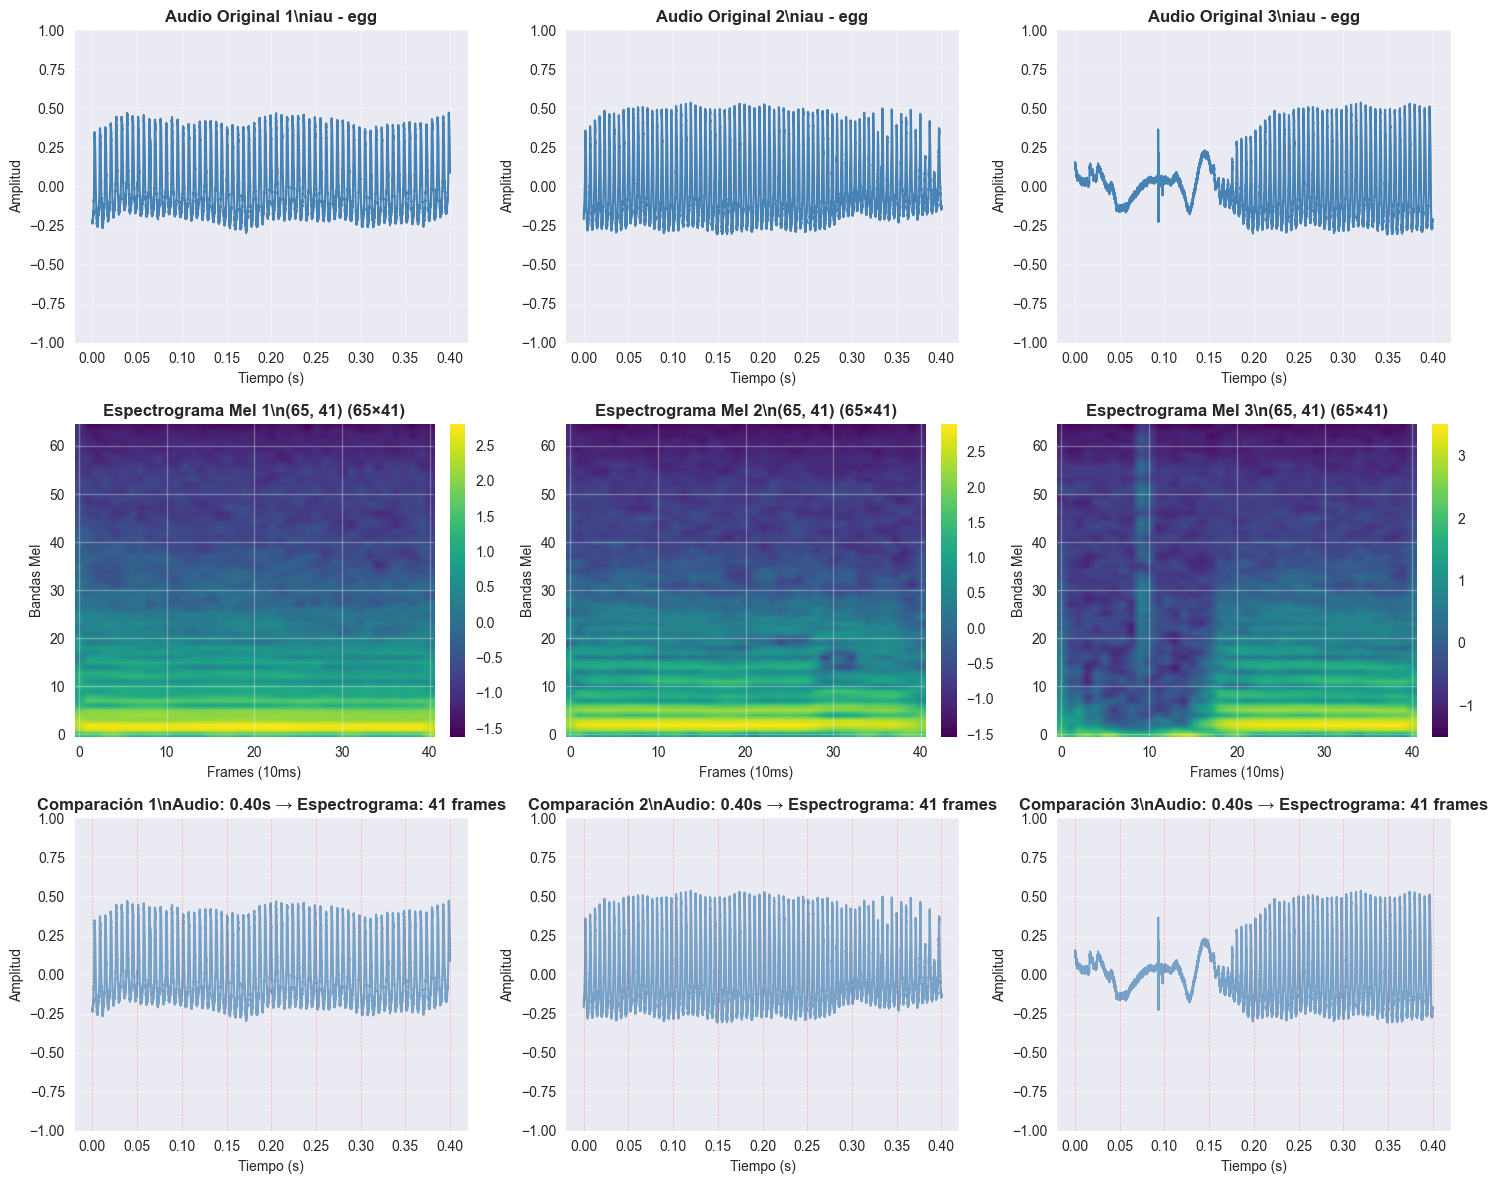

🔊 Audio 1: 1580-iau-egg.egg - iau - egg


🔊 Audio 2: 1580-iau-egg.egg - iau - egg


🔊 Audio 3: 1580-iau-egg.egg - iau - egg


\n📊 INFORMACIÓN DEL PROCESAMIENTO:
  - Audio original: 0.40s (400ms por segmento)
  - Espectrograma: 65×41 (65 bandas × 41 frames)
  - Frames temporales: 41 (cada 10ms)
  - Ventana FFT: 25ms para vocal iau
  - Normalización: z-score aplicada


In [9]:
# Visualización de señales de audio y espectrogramas
def visualize_audio_and_spectrograms(dataset, num_samples=3, sr=44100):
    """
    Visualiza señales de audio originales y sus espectrogramas procesados
    """
    if not dataset:
        print("❌ No hay datos para visualizar")
        return
    
    samples = random.sample(dataset, min(num_samples, len(dataset)))
    
    fig, axes = plt.subplots(3, num_samples, figsize=(5*num_samples, 12))
    if num_samples == 1:
        axes = axes.reshape(-1, 1)
    
    for i, sample in enumerate(samples):
        # Extraer metadatos y datos
        meta = sample['metadata']
        segment = sample['segment']
        spectrogram = sample['spectrogram']
        
        # 1. Audio original (segmento de 400ms)
        time_axis = np.linspace(0, len(segment)/sr, len(segment))
        axes[0, i].plot(time_axis, segment, linewidth=1.5, color='steelblue')
        axes[0, i].set_title(f'Audio Original {i+1}\\n{meta.vowel_type} - {meta.condition}', 
                           fontsize=12, fontweight='bold')
        axes[0, i].set_xlabel('Tiempo (s)', fontsize=10)
        axes[0, i].set_ylabel('Amplitud', fontsize=10)
        axes[0, i].grid(True, alpha=0.3)
        axes[0, i].set_ylim(-1, 1)
        
        # 2. Espectrograma Mel (procesado)
        im = axes[1, i].imshow(spectrogram, aspect='auto', origin='lower', 
                              cmap='viridis', interpolation='bilinear')
        axes[1, i].set_title(f'Espectrograma Mel {i+1}\\n{spectrogram.shape} (65×41)', 
                           fontsize=12, fontweight='bold')
        axes[1, i].set_xlabel('Frames (10ms)', fontsize=10)
        axes[1, i].set_ylabel('Bandas Mel', fontsize=10)
        axes[1, i].grid(True, alpha=0.3)
        plt.colorbar(im, ax=axes[1, i], fraction=0.046, pad=0.04)
        
        # 3. Comparación: Audio vs Espectrograma (superpuesto)
        axes[2, i].plot(time_axis, segment, linewidth=1.5, color='steelblue', alpha=0.7)
        axes[2, i].set_title(f'Comparación {i+1}\\nAudio: {len(segment)/sr:.2f}s → Espectrograma: {spectrogram.shape[1]} frames', 
                           fontsize=12, fontweight='bold')
        axes[2, i].set_xlabel('Tiempo (s)', fontsize=10)
        axes[2, i].set_ylabel('Amplitud', fontsize=10)
        axes[2, i].grid(True, alpha=0.3)
        axes[2, i].set_ylim(-1, 1)
        
        # Añadir líneas verticales para mostrar los frames del espectrograma
        frame_duration = 0.01  # 10ms por frame
        for frame in range(0, spectrogram.shape[1], 5):  # Cada 5 frames
            time_frame = frame * frame_duration
            if time_frame <= len(segment)/sr:
                axes[2, i].axvline(x=time_frame, color='red', alpha=0.3, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Reproducir audio
    for i, sample in enumerate(samples):
        meta = sample['metadata']
        print(f"🔊 Audio {i+1}: {meta.filename} - {meta.vowel_type} - {meta.condition}")
        display(Audio(sample['segment'], rate=sr))
    
    # Mostrar información del procesamiento (usando el último sample)
    last_sample = samples[-1]
    last_meta = last_sample['metadata']
    print(f"\\n📊 INFORMACIÓN DEL PROCESAMIENTO:")
    print(f"  - Audio original: {len(last_sample['segment'])/sr:.2f}s (400ms por segmento)")
    print(f"  - Espectrograma: {last_sample['spectrogram'].shape[0]}×{last_sample['spectrogram'].shape[1]} (65 bandas × 41 frames)")
    print(f"  - Frames temporales: {last_sample['spectrogram'].shape[1]} (cada 10ms)")
    print(f"  - Ventana FFT: {'40ms' if last_meta.vowel_type == 'a' else '25ms'} para vocal {last_meta.vowel_type}")
    print(f"  - Normalización: z-score aplicada")

# Visualizar si hay dataset procesado
try:
    if complete_dataset:
        print("🎨 Visualizando audio original vs espectrogramas procesados...")
        visualize_audio_and_spectrograms(complete_dataset, num_samples=3)
    else:
        print("⚠️ complete_dataset está vacío. Ejecuta las celdas anteriores primero.")
except NameError:
    print("⚠️ No hay dataset procesado. Ejecuta las celdas anteriores primero.")
